In [2]:
using LightGraphs, GraphPlot, Compose, PyPlot

In [10]:
# a function for BSGM_general (Section 2,3)

# y : a vector of data
# D : graph incidence matrix
# X : a design matrix
# w : a support vector
# nu : a prior precision for alpha
# v0, v1 : tuning parameters
# a, b : inverse gamma hyperparameters
# convtol : convergence tolerance
# orthotol : tolerance to check whether w is an eigenvector of X'X
# iter : a number of maximum allowed iteration

function BSGM_general(    y, D;                                 # a 
                          X = zeros(0,0), w = zeros(0),         # a design matrix and a support vector
                          nu = 0,                               # a prior precision for alpha
                          v0 = 1e-1, v1 = 1e4,                  # tuning parameters
                          a = 0, b = 1,                         # inverse gamma hyperparmeters
                          A = 1, B = 1,                         # beta bernoulli hyperparmeters
                          convtol = 1e-10, orthotol = 1e-10,    # tolerances
                          iter = 1000,                          # a number of maximum allowed iteration
                          verbose = true)                       # verbose option
    
    # n is the length of vector y
    n = length(y);
    m,p = size(D);
    if verbose == true
        println("A data \"y\" has input of length \"n\" = $n");
        println("A graph incidence matrix \"D\" has input of size (\"m\" = $m,\"p\" = $p)");
    end

    if size(X) == (0,0)
        if verbose == true
            println("A design matrix \"X\" has no input: use speye(n) as a default, \"n\" = $n");
        end
        X = speye(n);
    elseif size(X,1) != n
        error("Error: A data \"y\" has length \"n\" = $n thus a design matrix \"X\" must have $n rows.");
    end
    
    if length(w) == 0
        if verbose == true
            println("A support vector \"w\" has no input: use ones(p) as a default, \"p\" = $p");
        end
        w = ones(p);
    elseif length(w) != p
        error("Error: A graph incidence matrix \"D\" has \"p\" = $p columns thus a support vector \"w\" must have $p rows.");
    end
    
    if nu == 0
        # orthogonality check
        temp = X'*X*w;
        alpha = w'*X'*y / norm(w)^2;
        if norm(temp/norm(temp) - w/norm(w)) < orthotol && verbose == true
            println("\"w\" seems an eigenvector of \"X'*X\". We use a simpler algorithm.");
        end
    elseif nu == Inf
        alpha = 0;
    else
        Error("\"ν\" values other than 0 or ∞ are not being implemented yet.")
    end

    # initialization
    theta = (X'*X + 1e-4 * speye(p))\(X'*(y - alpha));
    delta = D * theta;
    if X == speye(n)
        sigmasq = sum((y - alpha).^2)/n;
    else
        sigmasq = 1;
    end
    eta = 1/2;
    q = ones(m)/2; q_old = copy(q);
    if verbose == true
        println("We initialize at \"α\" = mean(y), \"θ\" = y-α, \"σ^2\" = var(y) and \"η\" = 1/2");
    end

    # loop start
    for i = 1:iter
        
        # E-step : update q and tau
        q = 1./( 1 + (1-eta)/eta * sqrt(v0/v1) * exp.(delta.^2/2 * (1/v0 - 1/v1)/sigmasq) );
        tau = q/v0 + (1-q)/v1;
        
        # M-step : update theta, delta, sigma^2
        theta = (X'*X + D'*Diagonal(tau)*D) \ (X'*(y - alpha));
        theta = theta - (w'*theta) * w/norm(w)^2; # projection
        delta = D * theta;
        sigmasq = (sum((y - alpha - X*theta).^2) + sum((delta .* sqrt.(tau)).^2) + b)/(n+m+a+1);

        # convergence criterion
        err = norm(q - q_old)/length(q);
        
        # convergence check
        if err < convtol
            if verbose == true
                @printf "iteration: %d, error: %0.2e\n" i err;
                println("the algorithm converges at $i-th iteration");
            end
            break;
        end
        
        # printout
        if rem(i,5) == 0 && verbose == true
            @printf "iteration: %d, error: %0.2e\n" i err;
        end
        
        # update eta
        eta = (sum(q) + A - 1)/(m + A + B - 2);
        
        # save for convergence check
        q_old = copy(q);
    end
    return Dict([
                 (:alpha,alpha), (:theta,theta), (:delta, delta), (:q, q),
                 (:sigmasq,sigmasq), (:eta,eta), (:w, w)
               ])
end

BSGM_general (generic function with 1 method)

In [7]:
function model_selection(y, D, out; v1 = 1e4)
    # thresholding step
    ind = find(out[:q] .>= 0.5);
    
    # get a reduced model
    D_res = D[ind,:]
    L_res = D_res'*D_res;
    A_res = (abs.(L_res) - L_res)/2;
    
    # edge contraction / node merger
    g_res = Graph(A_res);
    c = connected_components(g_res)
    t = zeros(n); i = 0;
    for ind in c
        i += 1;
        t[ind] = mean(y[ind]);
    end
    
    # get a reduced model graph-algebraic objects
    s = length(c)
    A_reduced = zeros(s,s)
    for i = 1:s
        for j = i+1:s
            A_reduced[i,j] = sum(A[c[i],c[j]])
        end
    end
    A_reduced = (A_reduced .> 0)
    A_reduced = A_reduced + A_reduced';
    L_reduced = Diagonal(sum(A_reduced,2)[:]) - A_reduced;
    
    # model selection scores
    e_vals = eig(L_reduced/v1)[1][2:end]
    first_term = -sum(log.(e_vals))/2;
    second_term = sum(log.(1+e_vals))/2;
    third_term = log(sum((y-t).^2)) * n/2;
    
    return Dict([(:theta,t), (:score, first_term + second_term + third_term)])
end

model_selection (generic function with 1 method)

In [11]:
m = 21;
x = linspace(-1,1,m); loc_x = repeat(x,inner = m);
y = linspace(-1,1,m); loc_y = repeat(y,outer = m);
Th = cos.(sqrt.(x.^2 .+ y'.^2) * pi/2);
Theta = 5 * ceil.(2.8 * Th - 0.2);
theta = Theta[:]; n = length(theta);
sigma = 1.0;
srand(1);
y = theta + sigma * randn(n); Y = reshape(y,21,21);
g = Grid([21;21]; periodic=false);
A = adjacency_matrix(g);
D = -full(incidence_matrix(g, oriented = true))';
out = BSGM_general(y,D, v0 = 1e-3 * 10, v1 = 1e4, b = sum(size(D)), verbose = false)

Dict{Symbol,Any} with 7 entries:
  :alpha   => 5.32921
  :w       => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1…
  :eta     => 0.748557
  :theta   => [-10.2121, -10.2128, -10.2167, -10.2179, -5.32839, -5.32522, -5.3…
  :sigmasq => 1.33319
  :q       => [0.999664, 0.999664, 0.999664, 0.999664, 0.999664, 0.999664, 0.0,…
  :delta   => [0.000667633, 0.00113498, 0.00390052, -0.000572224, 0.00120819, -…

In [8]:
# model selection result
out_ms = model_selection(y, D, out, v1 = 1e4)

Dict{Symbol,Any} with 2 entries:
  :theta => [-4.88844, -4.88844, -4.88844, -4.88844, 0.00367979, 0.00367979, 0.…
  :score => 1384.1

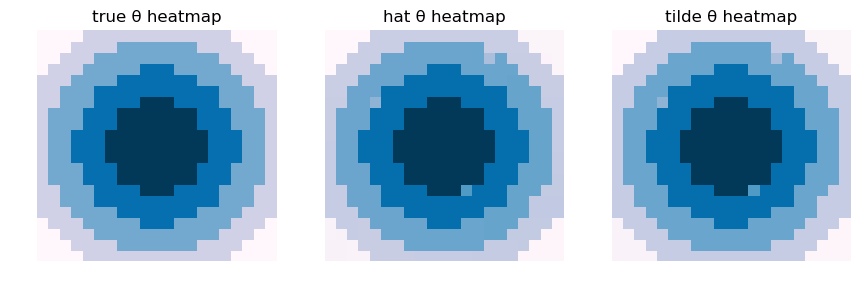

In [57]:
fig = figure(figsize = (10.5,3));
subplot(131); pcolormesh(Theta, cmap = "PuBu"); axis("off"); title("true θ heatmap");
subplot(132); pcolormesh(reshape(out[:theta],21,21), cmap = "PuBu"); axis("off"); title("hat θ heatmap");
subplot(133); pcolormesh(reshape(out_ms[:theta],21,21), cmap = "PuBu"); axis("off"); title("tilde θ heatmap");

In [62]:
srand(1);
n = 100; p = 200;
X = randn(n,p); X1 = [zeros(n) X];
w = [1;zeros(p)];
t = [zeros(Int(4*p/5));5.0*ones(Int(p/5))]
y = X*t + randn(n);
g = Graph(p+1);
for i = 1:p
    add_edge!(g,(1,i+1))
end
A = adjacency_matrix(g);
D = full(incidence_matrix(g, oriented = true))';
out1 = BSGM_general(y, D, v0 = 1e-1*0.8, X = X1, w = w, A = size(D,2), b = sum(size(D)), nu = Inf)

A data "y" has input of length "n" = 100
A graph incidence matrix "D" has input of size ("m" = 200,"p" = 201)
We initialize at "α" = mean(y), "θ" = y-α, "σ^2" = var(y) and "η" = 1/2
iteration: 5, error: 6.37e-03
iteration: 10, error: 5.01e-04
iteration: 15, error: 9.97e-05
iteration: 20, error: 2.43e-03
iteration: 25, error: 8.66e-04
iteration: 30, error: 2.97e-04
iteration: 35, error: 7.98e-04
iteration: 38, error: 6.64e-13
the algorithm converges at 38-th iteration


Dict{Symbol,Any} with 7 entries:
  :alpha   => 0
  :w       => [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0…
  :eta     => 0.899873
  :theta   => [0.0, -0.0191805, -0.0120603, 0.0715204, 0.0360596, -0.0695142, 0…
  :sigmasq => 1.34915
  :q       => [0.999685, 0.999685, 0.999678, 0.999683, 0.999678, 0.999685, 0.99…
  :delta   => [-0.0191805, -0.0120603, 0.0715204, 0.0360596, -0.0695142, 0.0137…

In [64]:
# model selection result
out1_ms = model_selection(y, D, out1, v1 = 1e4)

LoadError: [91mBoundsError: attempt to access 100-element Array{Float64,1} at index [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161]][39m

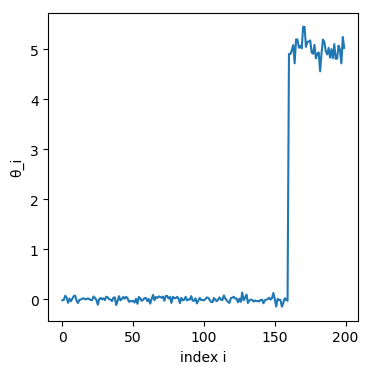

In [60]:
fig = figure(figsize = (9,4));
subplot(121);
plot(out1[:delta]); xlabel("index i"); ylabel("θ_i"); hat_gamma = (out1[:q] .> 0.5);
subplot(122);


In [ ]:
gamma = (t .== 0);
println("misclassificiation rate: ", sum(gamma .* (1-hat_gamma)) + sum((1-gamma) .* hat_gamma))